# Zion Data Analysis Notebook

Defs, Imports, etc

In [1]:
import os, sys
from glob import glob
import time
from collections import UserDict, UserString
import numpy as np
import pandas as pd
from skimage.color import rgb2hsv
from skimage import filters, morphology, segmentation, measure
from scipy.optimize import nnls
from tifffile import imread, imwrite
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [11, 8]

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(os.path.join(module_path))
    

from ImageProcessing.ZionImage import ZionImage, create_labeled_rois, get_wavelength_from_filename, get_cycle_from_filename, get_time_from_filename, get_imageset_from_cycle
from ImageProcessing.ZionBaseCaller import crosstalk_correct, display_signals, create_phase_correct_matrix, base_call, add_basecall_result_to_dataframe, project_color
from ImageProcessing.ZionData import df_cols, extract_spot_data, csv_to_data, add_basecall_result_to_dataframe

### Give the notebook a directory of tiffs to work in and some parameters:

In [2]:
input_dir_path = "C:\\Users\\ZacharyAugenfeld\\Documents\\ZionData\\\OnePotNoWash"

# This parameter determines whether temporal difference images are used
useDifferenceImage = False

# This is the name of the UV channel
uv_wl = "365"

# This determines what type of background subtraction is used
bgSubtract = False

useTiff = False

# This was used to help with file identification
#bTiff = False


## Step 1: Spot Detection

### Define parameters used in spot detection. 

When you run this cell, ROIs will be displayed. Verify you get the spots you want. (If not, adjust parameters here and re-run.)

Detecting ROIs using median=9, erode=30, dilate=30, scale=1
84 spot candidates found


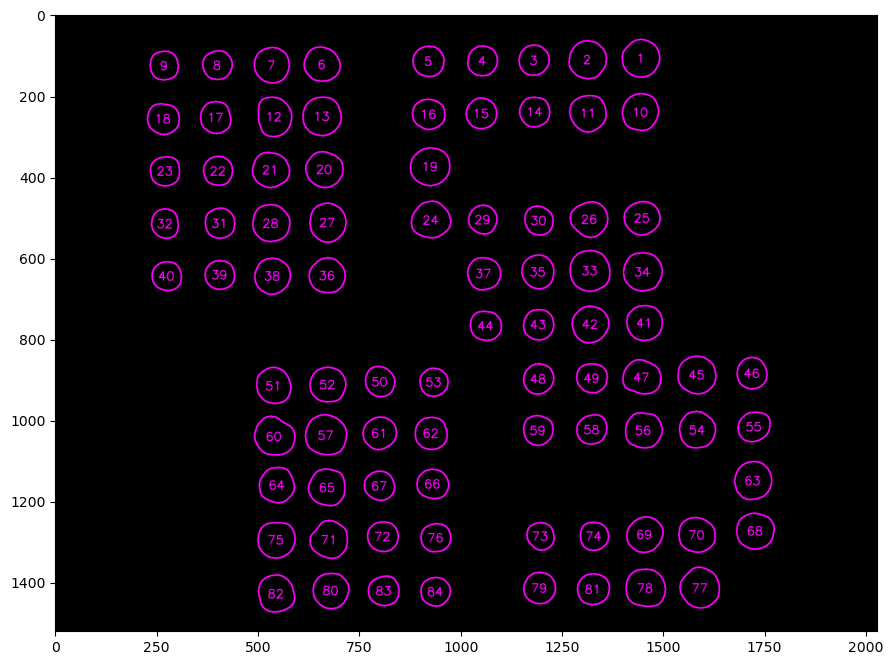

In [3]:
# This determines size of noise filter kernel (prob doesn't need to be changed much)
median_kernel_size = 9

# These tune spot size and how much spot border is included
erode_kernel_size = 30
dilate_kernel_size = 30

# This adjusts sensitivity for thresholding (should be close to 1)
threshold_scale = 1

# These are constraints on how large or small a spot could be
spotMinSize = 1200
spotMaxSize = None

# This is a list of RGB weights when turning the (UV) image to grayscale
rgb_weights = (0.4, 0.2, 0.1)
#rgb_weights = None

'''If roi_label_imagefile is set to None, spot detection will be performed.
   If it is set to a file, it will load spot ROIs and NOT run spot detection,
   and the above spot detection parameters will be ignored.'''

roi_label_imagefile = None
#roi_label_imagefile = "roi_map.tif" #useful if already run



#### DO NOT EDIT BELOW THIS LINE ####
cycle1ImageSet = get_imageset_from_cycle(1, input_dir_path, uv_wl, useDifferenceImage, useTiff=useTiff)

if roi_label_imagefile is not None:
    spot_labels = imread(os.path.join(input_dir_path, roi_label_imagefile))
else:
    _,spot_labels,_ = cycle1ImageSet.detect_rois( os.path.join(input_dir_path), median_ks=median_kernel_size, erode_ks=erode_kernel_size, dilate_ks=dilate_kernel_size, threshold_scale=threshold_scale, minSize=spotMinSize, maxSize=spotMaxSize, gray_weights=rgb_weights)

rois_img = create_labeled_rois(spot_labels, notebook=True)
imwrite(os.path.join(input_dir_path, "rois_img.tif"), rois_img)
plt.imshow(rois_img)

#TODO fix other excitation images with ROI overlay (works on pi so condition off of notebook=True)

Now you can remove spots by listing their labels in list of exclusions below, or add spots by attaching a label image (eg an ROI map tif file from ImageJ).

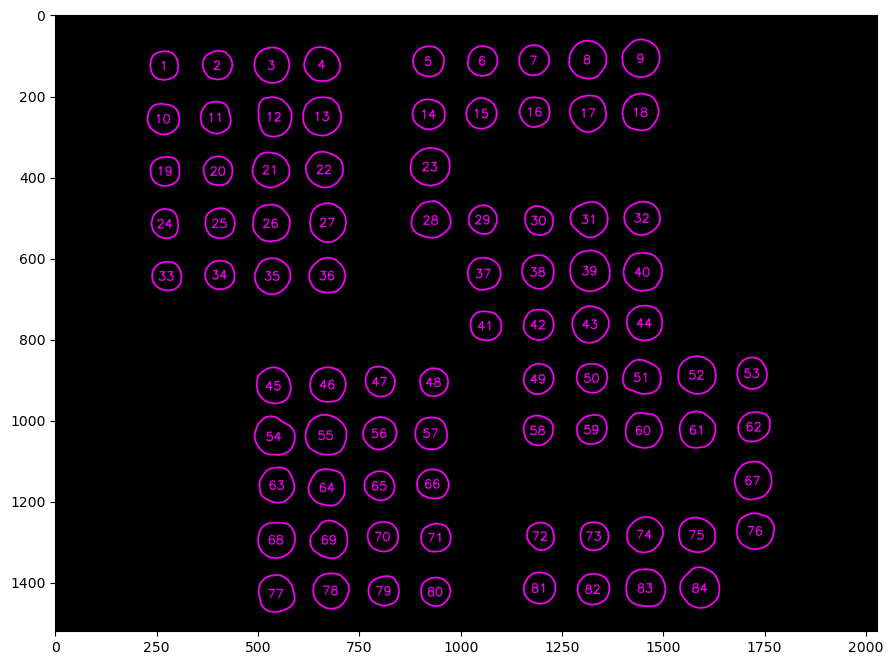

In [4]:
#exclusions = [5,16,19,24,46,55,63,68] #FAM dye fiducials - omit?
exclusions = []

new_order =[ 9, 8, 7, 6,   5,    4, 3, 2, 1,
            18,17,12,13,  16,   15,14,11,10,
            23,22,21,20,  19,
            32,31,28,27,  24,   29,30,26,25,
            40,39,38,36,        37,35,33,34,
                                44,43,42,41,
            51,52,50,53,        48,49,47,45,  46,
            60,57,61,62,        59,58,56,54,  55,
            64,65,67,66,                      63,
            75,71,72,76,        73,74,69,70,  68,
            82,80,83,84,        79,81,78,77
           ]

label_image_to_fuse = None
#label_image_to_fuse = "Roi Map.tif"

#### DO NOT EDIT BELOW THIS LINE ####
for spot in range(1, 1+np.max(spot_labels)):
    if spot in exclusions:
        spot_labels[spot_labels==spot]=0
        
binary_img1 = spot_labels.astype(bool)
binary_img2 = imread(os.path.join(input_dir_path, label_image_to_fuse)).astype(bool) if label_image_to_fuse is not None else np.zeros_like(binary_img1)

spot_labels2 = measure.label(np.logical_or(binary_img1, binary_img2))
spot_labels3 = np.zeros_like(spot_labels2)
for spot_label in new_order:
    spot_labels3[spot_labels2==spot_label]=new_order.index(spot_label)+1

rois_img = create_labeled_rois(spot_labels3, notebook=True)
imwrite(os.path.join(input_dir_path, "rois_img.tif"), rois_img)
plt.imshow(rois_img)
spot_labels = spot_labels3
imwrite(os.path.join(input_dir_path,"roi_labels.tiff"), spot_labels)

## Step 2: Define color dictionary

Either provide a file OR select spot (by label) for each base:

In [5]:
# For each base, provide purest spot (by label in image above): 
color_A_spots = [33]
color_C_spots = [10]
color_G_spots = [19]
color_T_spots = [1]

'''If basis_colors_file is set to None, spot detection will be performed.
   If it is set to a file, it will load color dictionary from file,
   ignoring the above basis color spots.'''

basis_colors_file = None
#basis_colors_file = os.path.join(input_dir_path, "M.npy")

# Define what spot is used as background/reference spot
# Note that this is only used if bgSubtract above is True
bg_spot = None

#### DO NOT EDIT BELOW THIS LINE ####
if basis_colors_file is not None:
    M = np.load(basis_colors_file)
else:
    M = np.zeros(shape=(3*(cycle1ImageSet.nChannels), 4))
    nSpots = np.max(spot_labels) # assumes we've already reindexed
    for base_spot_ind, base_spotlist in enumerate( (color_A_spots, color_C_spots, color_G_spots, color_T_spots) ):
        vec_list = []
        for base_spot in base_spotlist:
            vec_list.append( cycle1ImageSet.get_mean_spot_vector(spot_labels==base_spot) )
        #TODO: should we normalize the vector here?
        vec = np.mean(np.array(vec_list), axis=0)
        M[:,base_spot_ind] = vec
    np.save(os.path.join(input_dir_path, "M.npy"), M)
print(f"M = \n{M}")

M = 
[[10223.8590998   8818.88968876  5978.03132416  8022.72364096]
 [ 6579.92563601 13324.94600889 11710.32747983  5687.07357775]
 [ 4584.71624266  5077.7963159   5505.91741813  4608.56232617]
 [ 9702.93933464  8753.5989837  10688.92643569  9347.87560051]
 [ 6524.59491194 12645.5202202  36558.41480778  6438.95828066]
 [ 4606.04696673  5066.64408215 10307.88799241  4841.38154235]
 [13067.41682975 18736.96548804  9524.70431894  6663.6460177 ]
 [ 9548.40313112 34308.18039382 27672.7081158   7105.0437421 ]
 [ 5229.44422701  7562.74232479 11916.19174181  4826.8460177 ]
 [33573.27984344  9188.10247724  9568.         27598.06219975]
 [14833.86888454  7581.01884396  7506.09776934 12633.03767383]
 [ 6330.90802348  4656.23036206  4576.69862364  6909.07509482]
 [20331.1037182  11284.72242219 15903.41148552 51542.72364096]
 [ 9340.64774951  6235.74677112  8505.6345515  19865.7011378 ]
 [ 5482.47749511  4775.30721999  5123.24252492  9749.82553729]]


## Step 3: Extract spot data and write to CSV

In [6]:
numCycles = 5

csvfile = os.path.join(input_dir_path, "basecaller_spot_data.csv")
with open(csvfile, "w") as f:
    f.write(','.join(df_cols)+'\n')
    
for new_cycle in range(1,numCycles+1):
    currImageSet = get_imageset_from_cycle(new_cycle, input_dir_path, uv_wl, useDifferenceImage, useTiff=useTiff)
    print(currImageSet.cycle)
    spot_data = extract_spot_data(currImageSet, spot_labels, csvFileName=csvfile)

#needed to spoof 6 cycles collected for analysis
new_cycle = numCycles+1
currImageSet = get_imageset_from_cycle(new_cycle-1, input_dir_path, uv_wl, useDifferenceImage, useTiff=useTiff)
currImageSet.cycle = new_cycle
print(currImageSet.cycle)
spot_data = extract_spot_data(currImageSet, spot_labels, csvFileName=csvfile)
numCycles += 1


1
                             mean_R        mean_G       mean_B        mean_R  \
                                365           365          365           445   
roi      time   cycle                                                          
spot_001 599424 1       8022.723641   5687.073578  4608.562326   9347.875601   
spot_002 599424 1       8455.408945   5889.816654  4660.214480  10145.510255   
spot_003 599424 1       8335.970335   5815.106017  4646.310467   9790.994101   
spot_004 599424 1       7436.023977   5522.727864  4545.197465   8671.835588   
spot_005 599424 1       6922.487514  17847.213260  6756.822983  15631.512044   
...                             ...           ...          ...           ...   
spot_080 599424 1      10778.599005   6856.969154  4642.583085  10338.606965   
spot_081 599424 1       9514.301831  14730.571248  5244.713113   8350.208377   
spot_082 599424 1       9387.022147  14510.368277  5214.801941   8148.606623   
spot_083 599424 1       8958.669054  1

                             mean_R        mean_G       mean_B        mean_R  \
                                365           365          365           445   
roi      time    cycle                                                         
spot_001 1802915 3      7928.285209  10000.151707  4813.172187   8253.613148   
spot_002 1802915 3      8267.939708  10565.418335  4876.485298   8995.783543   
spot_003 1802915 3      8273.299848  10685.564807  4878.605764   8503.869206   
spot_004 1802915 3      7385.489296   9265.840041  4717.188560   7537.693441   
spot_005 1802915 3      6757.859006  17131.307845  6622.451271  15245.652155   
...                             ...           ...          ...           ...   
spot_080 1802915 3      8100.995025  11142.871642  5184.338308   8663.765174   
spot_081 1802915 3      7327.939381   6646.976216  4653.352978   7648.855399   
spot_082 1802915 3      7191.630458   6533.047036  4631.292976   7403.450749   
spot_083 1802915 3      6938.788597   65

                             mean_R        mean_G       mean_B        mean_R  \
                                365           365          365           445   
roi      time    cycle                                                         
spot_001 3006435 5      7275.274842   7392.766625  4520.960809   7545.587863   
spot_002 3006435 5      7612.354831   7765.200890  4573.896714   8190.276254   
spot_003 3006435 5      7482.050902   7736.498904  4565.630878   7724.877128   
spot_004 3006435 5      6674.926529   6873.367357  4456.957698   6925.668094   
spot_005 3006435 5      6528.053039  16117.171271  6441.380773  14982.796022   
...                             ...           ...          ...           ...   
spot_080 3006435 5      8755.422886   8296.127363  4711.096517   8170.622886   
spot_081 3006435 5      6750.060198   7009.998737  4523.921701   6828.544727   
spot_082 3006435 5      6631.060114   6904.796456  4505.527104   6568.963510   
spot_083 3006435 5      6396.357527   68

## Step 4: Perform base-calling

### First, determine signal pre-phase-correction:
Define number of cycles COLLECTED (phase-corrected output of base-caller will be 1 fewer):

In [8]:
#### DO NOT EDIT BELOW THIS LINE ####
# todo kinetics figure, similar to below
# generate pre-phase-correction histograms:
basecall_csv = csvfile

#todo: add option to use median instead of mean

basecall_pd = csv_to_data(basecall_csv)
basecall_data = basecall_pd.to_numpy()
#print(basecall_pd.index.get_level_values('roi').to_list())
signal_pre_basecall, spotlist, basecall_pd_pre = crosstalk_correct(basecall_pd, M, numCycles)

spotlist = sorted(spotlist)
basecall_pd_pre.to_csv(os.path.join(input_dir_path, "basecaller_output_data_pre.csv"))
print(spotlist)

['spot_001', 'spot_002', 'spot_003', 'spot_004', 'spot_005', 'spot_006', 'spot_007', 'spot_008', 'spot_009', 'spot_010', 'spot_011', 'spot_012', 'spot_013', 'spot_014', 'spot_015', 'spot_016', 'spot_017', 'spot_018', 'spot_019', 'spot_020', 'spot_021', 'spot_022', 'spot_023', 'spot_024', 'spot_025', 'spot_026', 'spot_027', 'spot_028', 'spot_029', 'spot_030', 'spot_031', 'spot_032', 'spot_033', 'spot_034', 'spot_035', 'spot_036', 'spot_037', 'spot_038', 'spot_039', 'spot_040', 'spot_041', 'spot_042', 'spot_043', 'spot_044', 'spot_045', 'spot_046', 'spot_047', 'spot_048', 'spot_049', 'spot_050', 'spot_051', 'spot_052', 'spot_053', 'spot_054', 'spot_055', 'spot_056', 'spot_057', 'spot_058', 'spot_059', 'spot_060', 'spot_061', 'spot_062', 'spot_063', 'spot_064', 'spot_065', 'spot_066', 'spot_067', 'spot_068', 'spot_069', 'spot_070', 'spot_071', 'spot_072', 'spot_073', 'spot_074', 'spot_075', 'spot_076', 'spot_077', 'spot_078', 'spot_079', 'spot_080', 'spot_081', 'spot_082', 'spot_083', 'sp

### Next, define p and q for phase correction matrix:

In [9]:
p = 0.015   # Probability that ZERO new base synthesized during a cycle (lagging)
q = 0.127   # Probability that TWO new bases synthesized during a cycle (leading)

#### DO NOT EDIT BELOW THIS LINE ####
Qinv = create_phase_correct_matrix(p,q,numCycles)
signal_post_basecall = np.transpose( (np.transpose(signal_pre_basecall, axes=(0,2,1)) @ Qinv)[:,:,:-1], axes=(0,2,1))
basecall_pd_post = add_basecall_result_to_dataframe(signal_post_basecall, basecall_pd)
basecall_pd_post.to_csv(os.path.join(input_dir_path, "basecaller_output_data_post.csv"))


### Now display results and write to report
Define report filename and number of rows in figure outputs.

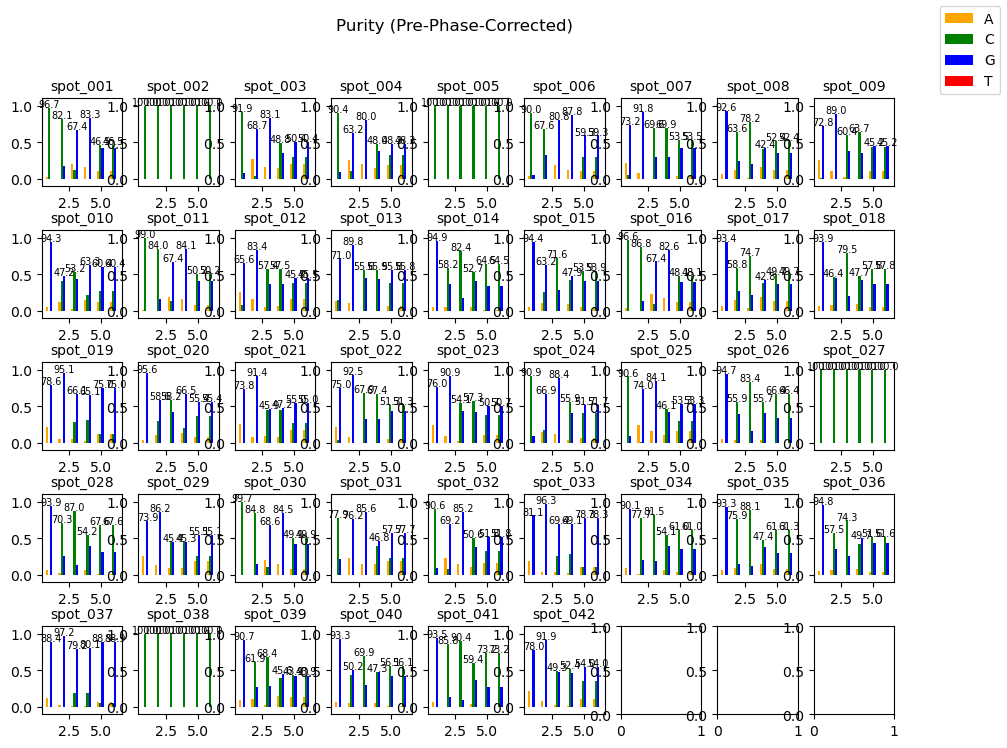

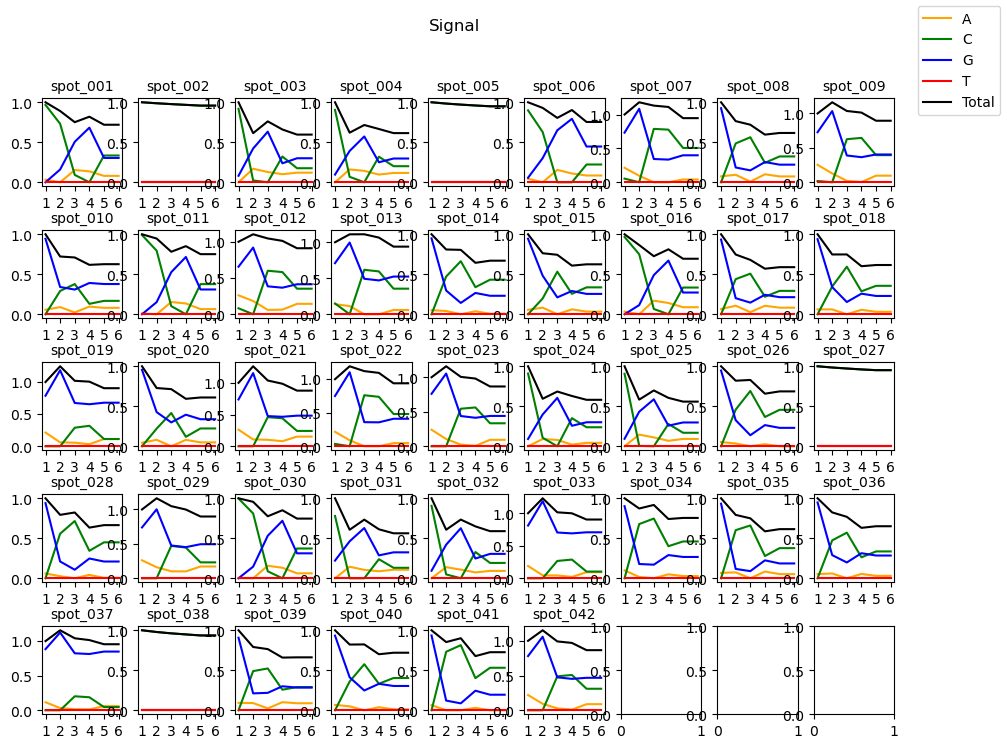

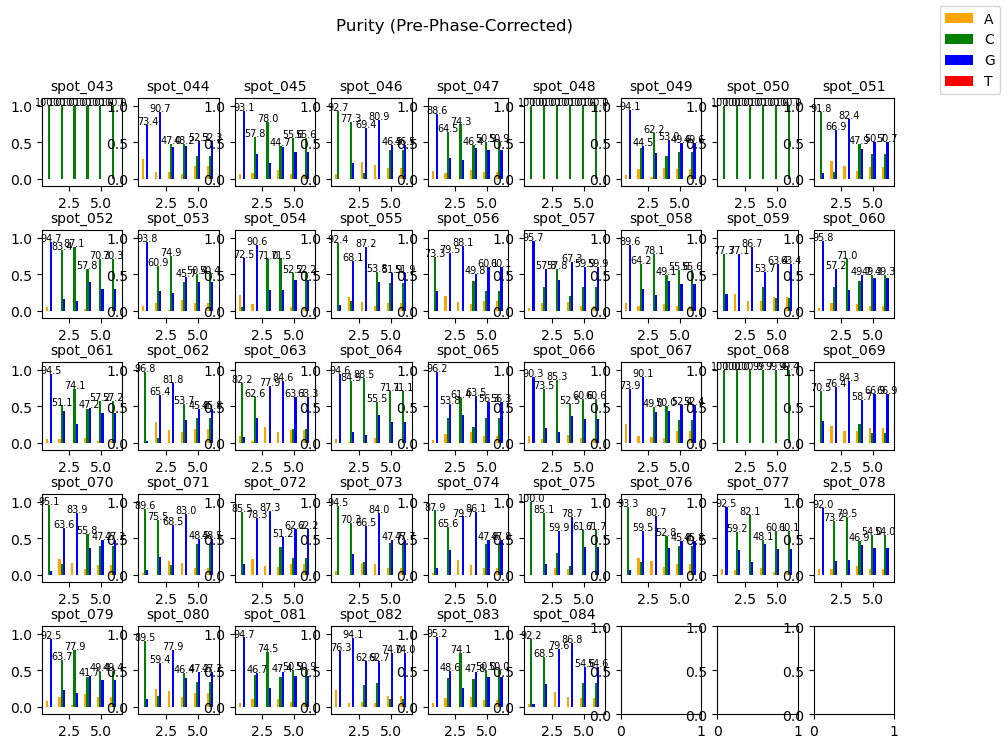

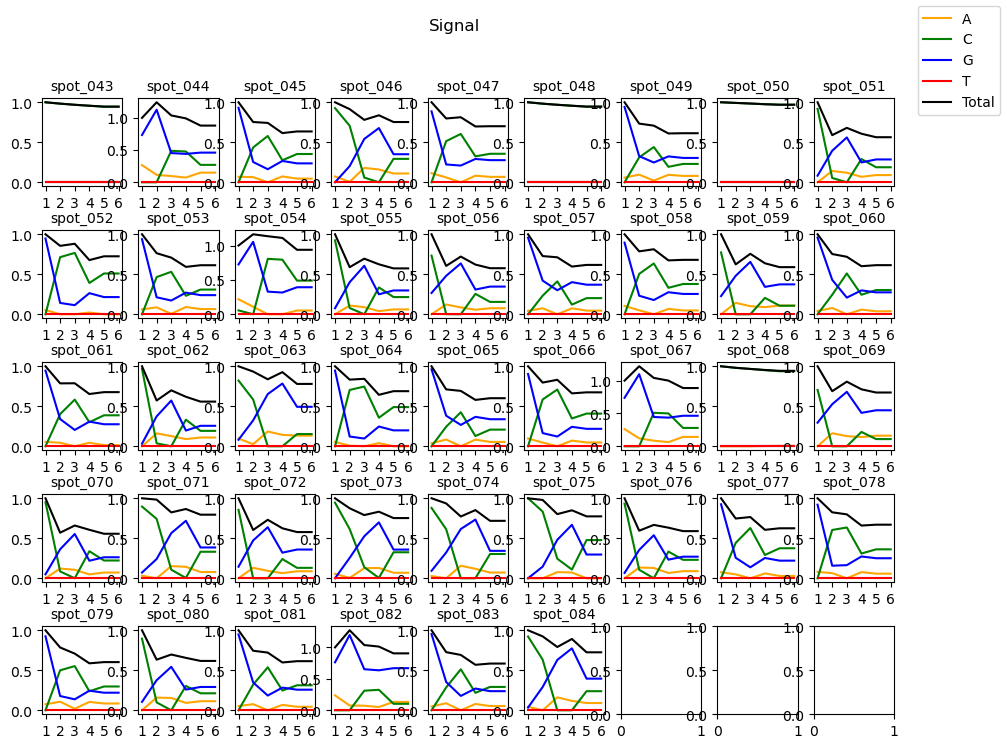

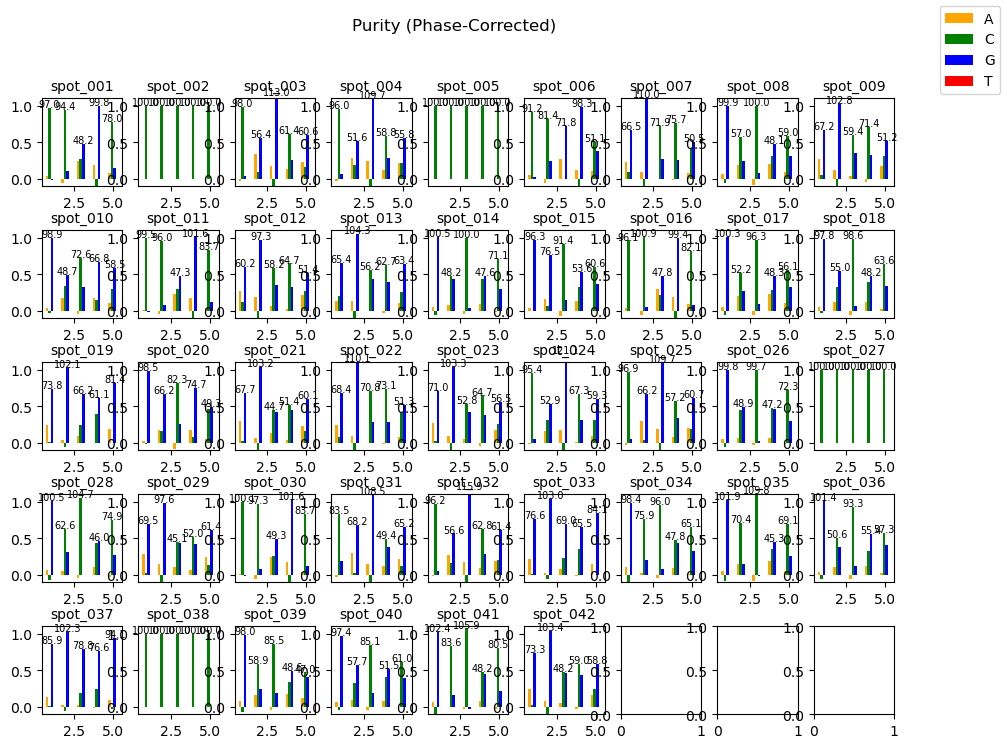

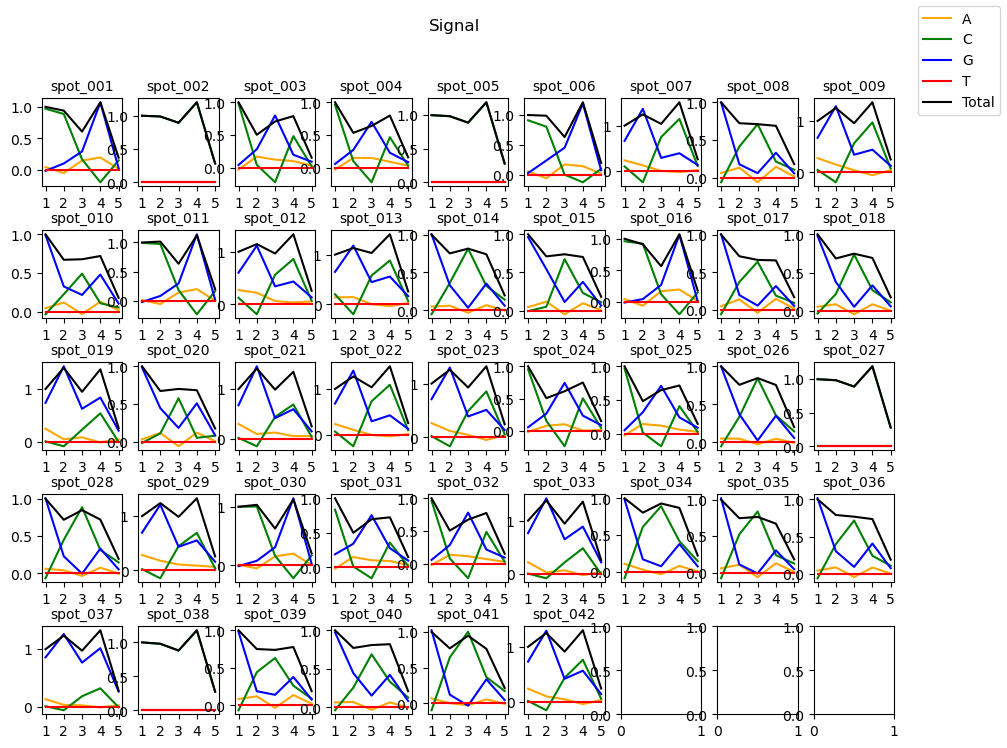

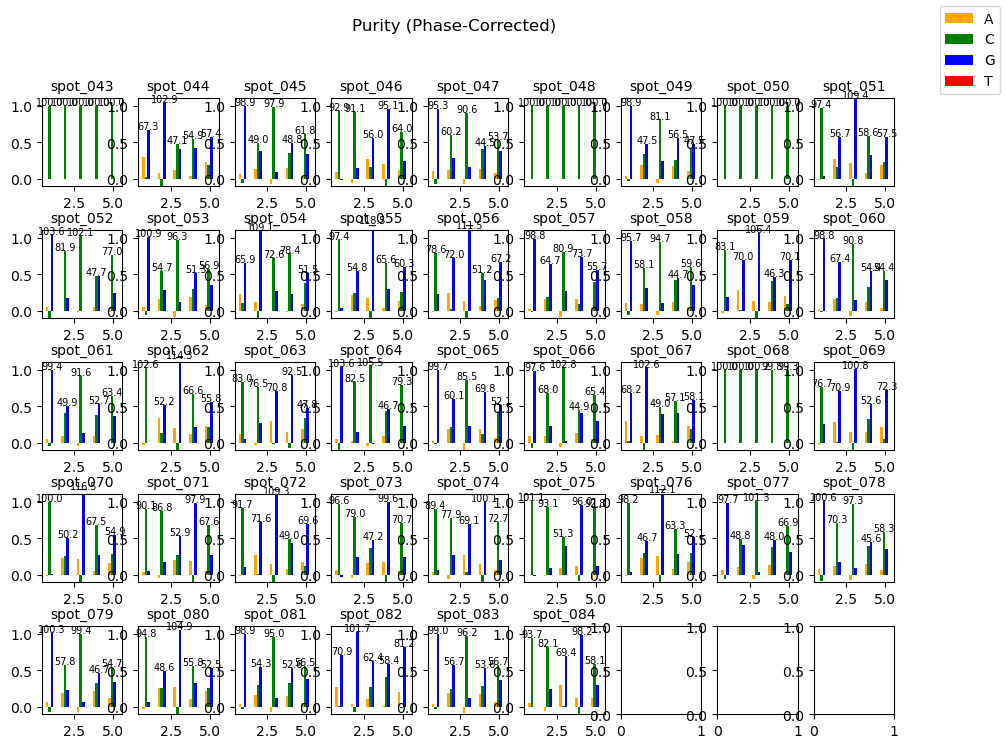

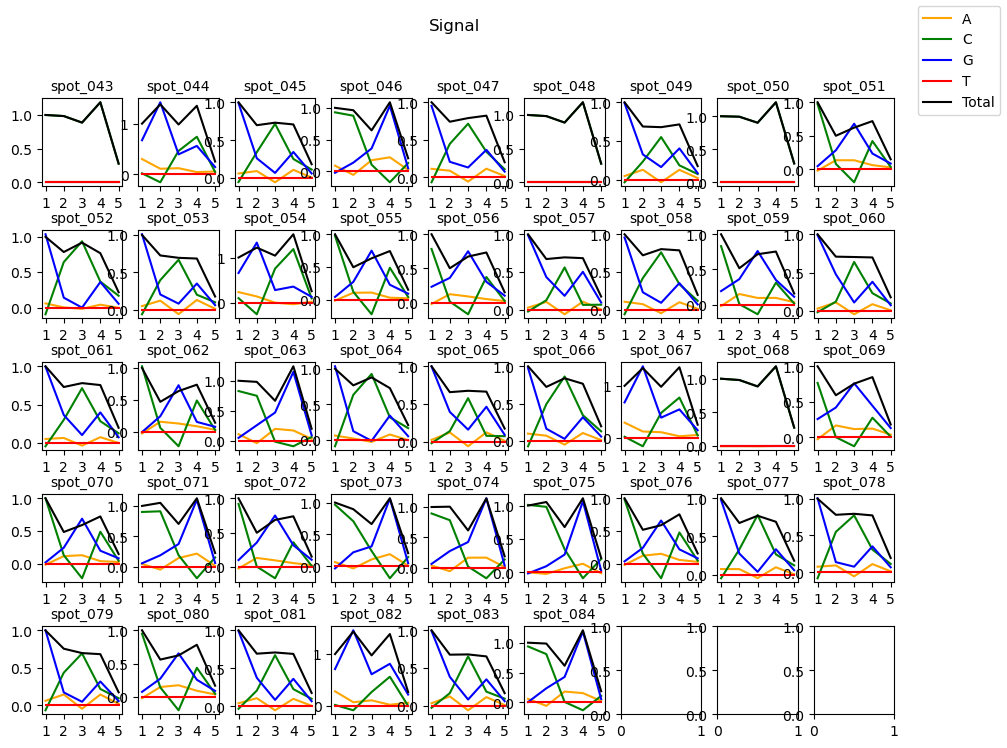

In [10]:
# You can name report file here:
reportfile = os.path.join(input_dir_path, "report.txt")

figNumRows = 5
figNumPages = 2

#TODO: spot name lookup table

#### DO NOT EDIT BELOW THIS LINE ####
f1, f2 = display_signals(signal_pre_basecall, spotlist, numCycles, numRows=figNumRows, numPages=figNumPages, preOrPost="pre")
f3, f4 = display_signals(signal_post_basecall, spotlist, numCycles-1, numRows=figNumRows, numPages=figNumPages, preOrPost="post")

for f_idx, f in enumerate(f1):
    f.savefig(os.path.join(input_dir_path, f"Purity Pre-Phase {f_idx+1}.png"))
for f_idx, f in enumerate(f2):
    f.savefig(os.path.join(input_dir_path, f"Signal Pre-Phase {f_idx+1}.png"))
for f_idx, f in enumerate(f3):
    f.savefig(os.path.join(input_dir_path, f"Purity Post-Phase {f_idx+1}.png"))
#for f_idx, f in enumerate(f4):
#    f.savefig(os.path.join(input_dir_path, f"Signal Post-Phase {f_idx+1}.png"))

#TODO add more metrics to report
#TODO package up as pdf?    

with open(reportfile, 'w') as f:
    if useDifferenceImage:
        print(f"Difference = Temporal", file=f)
    else:
        print(f"Difference = Dark", file=f)

    print(f"Median Filter Kernel Size = {median_kernel_size}", file=f)
    print(f"Erosion Kernel Size = {erode_kernel_size}", file=f)
    print(f"Dilation Kernel Size = {dilate_kernel_size}", file=f)
    print(f"Mean Threshold Scale Factor = {threshold_scale}", file=f)
    print(f"ROI labels at {os.path.join(input_dir_path, 'rois.jpg')}", file=f)
    print(f"'Cross-talk' matrix M = {M}", file=f)
    #todo list where output csv is?
    print(f"Pre-phase corrected Purity at {os.path.join(input_dir_path, 'Purity Pre-Phase.png')}", file=f)
    print(f"Pre-phase corrected Signal {os.path.join(input_dir_path, 'Signal Pre-Phase.png')}", file=f)
    print(f"Base-caller p = {p}", file=f)
    print(f"Base-caller q = {q}", file=f)
    print(f"Post-phase corrected Purity at {os.path.join(input_dir_path, 'Purity Post-Phase.png')}", file=f)
    print(f"Post-phase corrected Signal {os.path.join(input_dir_path, 'Signal Post-Phase.png')}", file=f)

In [ ]:
print(spot_data)